In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import preprocessing
import seaborn as sns
from imblearn.pipeline import Pipeline
import shap
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import pickle
import seaborn as sns
sns.set(style="white")

# For reproducibility
np.random.seed(42)

In [13]:
X_train = np.load('X_train_PE_no_lab_measurement.npy')
X_test = np.load('X_test_PE_no_lab_measurement.npy')
y_train = np.load('y_train_PE_no_lab_measurement.npy')
y_test = np.load('y_test_PE_no_lab_measurement.npy')

In [14]:
# Scale age
pre = preprocessing.StandardScaler()

age_column = X_train[:, 0]
age_column = np.atleast_2d(age_column).T

X_train[:, 0] = pre.fit_transform(age_column).ravel()

age_column = X_test[:, 0]
age_column = np.atleast_2d(age_column).T

X_test[:, 0] = pre.transform(age_column).ravel()

In [15]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# XGBoost without resampling

In [91]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]

# Create the grid
param_grid = {'max_depth': max_depth,
               'n_estimators': n_estimators,
               'learning_rate': lr,
               'max_delta_step': max_delta_step}

In [31]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [33]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(XGBOOSTmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:14:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:16:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:21:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:50:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:50:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:51:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:02:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:02:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:22:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:24:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:26:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[12:59:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:03:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[13:28:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:28:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:29:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:02:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:03:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[14:43:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:45:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_...
                                      random_state=None, reg_alpha=None,
                                      reg_lambda=None, scale_pos_weight=None,
                                      subsample=None, tree_method=None,
                                      use_label_encoder=False,
                          

In [34]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_depth', 6), ('n_estimators', 150)])
Best AUROC: 0.9140048268921241


Best parameter combo: OrderedDict([('learning_rate', 0.1), ('max_depth', 6), ('n_estimators', 150)])
Best AUROC: 0.9140048268921241

In [5]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 6, n_estimators = 150,learning_rate = 0.1, use_label_encoder=False)

In [6]:
XGBOOSTmodel.fit(X_train, np.ravel(y_train))

[09:34:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [39]:
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.9124337533956077
Accuracy is: 0.9926906399765266
Average Precision is: 0.07982208449175486


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


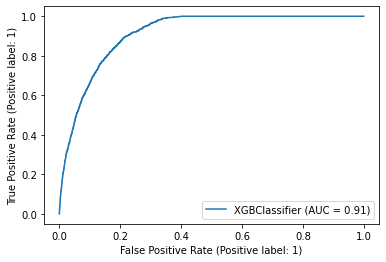

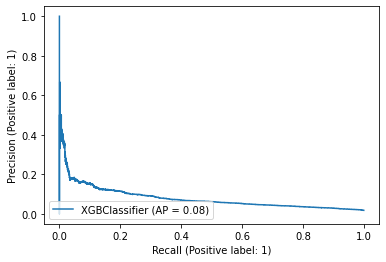

In [40]:
# Make metric plots
metrics.plot_roc_curve(XGBOOSTmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(XGBOOSTmodel, X_test, y_test) 
plt.show()

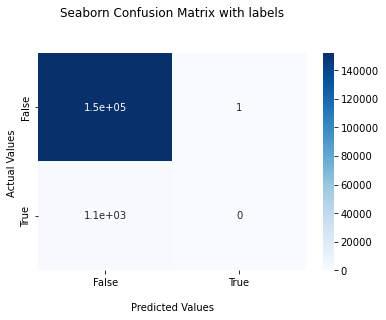

In [46]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [49]:
# save the model trained on training set
pickle.dump(XGBOOSTmodel, open("models/xgb_PE_no_lab_measurements.pkl", "wb"))

In [194]:
# search thresholds for imbalanced classification
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

yhat = XGBOOSTmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.0001)
# evaluate each threshold satisfying the metric
scores = [metrics.roc_auc_score(y_train, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, AUROC-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.011, AUROC-Score=0.86572


In [195]:
y_pred = (XGBOOSTmodel.predict_proba(X_test)[:,1] >= 0.011).astype(int) # set threshold as 0.3

print('AUROC is:', metrics.roc_auc_score(y_test, y_pred))
print('Accuracy is:', metrics.accuracy_score(y_test, y_pred))
print('Average Precision is:', metrics.average_precision_score(y_test, y_pred))

AUROC is: 0.8319451612297847
Accuracy is: 0.8106347602125648
Average Precision is: 0.02842116731863156


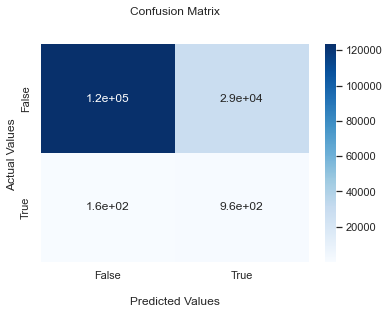

In [196]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [197]:
# Sensitivity is recall of positive class
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    152245
           1       0.03      0.85      0.06      1120

    accuracy                           0.81    153365
   macro avg       0.52      0.83      0.48    153365
weighted avg       0.99      0.81      0.89    153365



In [7]:
# Get feature importance
explainer = shap.TreeExplainer(XGBOOSTmodel)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


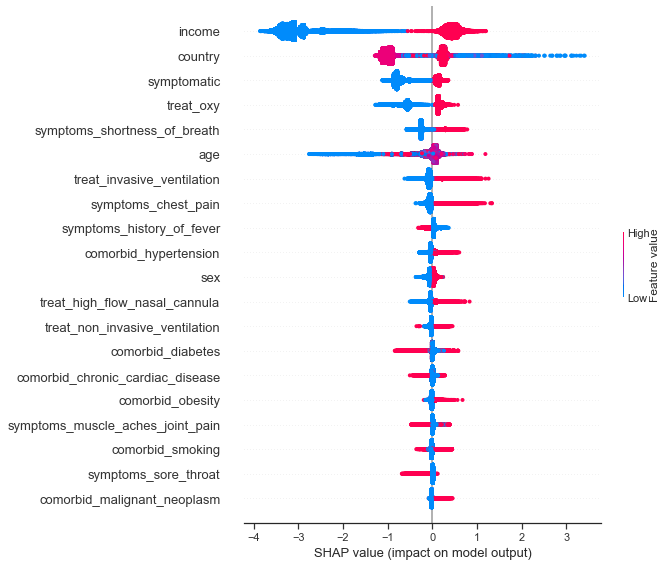

In [8]:
features = ['age', 'sex', 'country', 'income', 'comorbid_aids_hiv',
       'comorbid_asthma', 'comorbid_chronic_cardiac_disease',
       'comorbid_chronic_haematological_disease',
       'comorbid_chronic_kidney_disease',
       'comorbid_chronic_neurological_disorder',
       'comorbid_chronic_pulmonary_disease', 'comorbid_dementia',
       'comorbid_diabetes', 'comorbid_hypertension',
       'comorbid_immunosuppression', 'comorbid_liver_disease',
       'comorbid_malignant_neoplasm', 'comorbid_malnutrition',
       'comorbid_obesity', 'comorbid_rheumatologic_disorder',
       'comorbid_smoking', 'comorbid_tuberculosis', 'symptomatic',
       'symptoms_abdominal_pain', 'symptoms_altered_consciousness_confusion',
       'symptoms_bleeding', 'symptoms_chest_pain', 'symptoms_conjunctivitis',
       'symptoms_cough', 'symptoms_diarrhoea', 'symptoms_ear_pain',
       'symptoms_fatigue_malaise', 'symptoms_headache',
       'symptoms_history_of_fever', 'symptoms_lost_altered_sense_of_smell',
       'symptoms_lost_altered_sense_of_taste', 'symptoms_lymphadenopathy',
       'symptoms_muscle_aches_joint_pain', 'symptoms_runny_nose',
       'symptoms_seizures', 'symptoms_severe_dehydration',
       'symptoms_shortness_of_breath', 'symptoms_skin_rash',
       'symptoms_sore_throat', 'symptoms_vomiting_nausea', 'symptoms_wheezing',
       'treat_extracorporeal', 'treat_high_flow_nasal_cannula',
       'treat_inhaled_nitric_oxide', 'treat_invasive_ventilation',
       'treat_non_invasive_ventilation', 'treat_respiratory_support',
       'treat_tracheostomy', 'treat_oxy']
shap.summary_plot(shap_values, X_test, feature_names=features)

Text(0.5, 0, 'Permutation Importance')

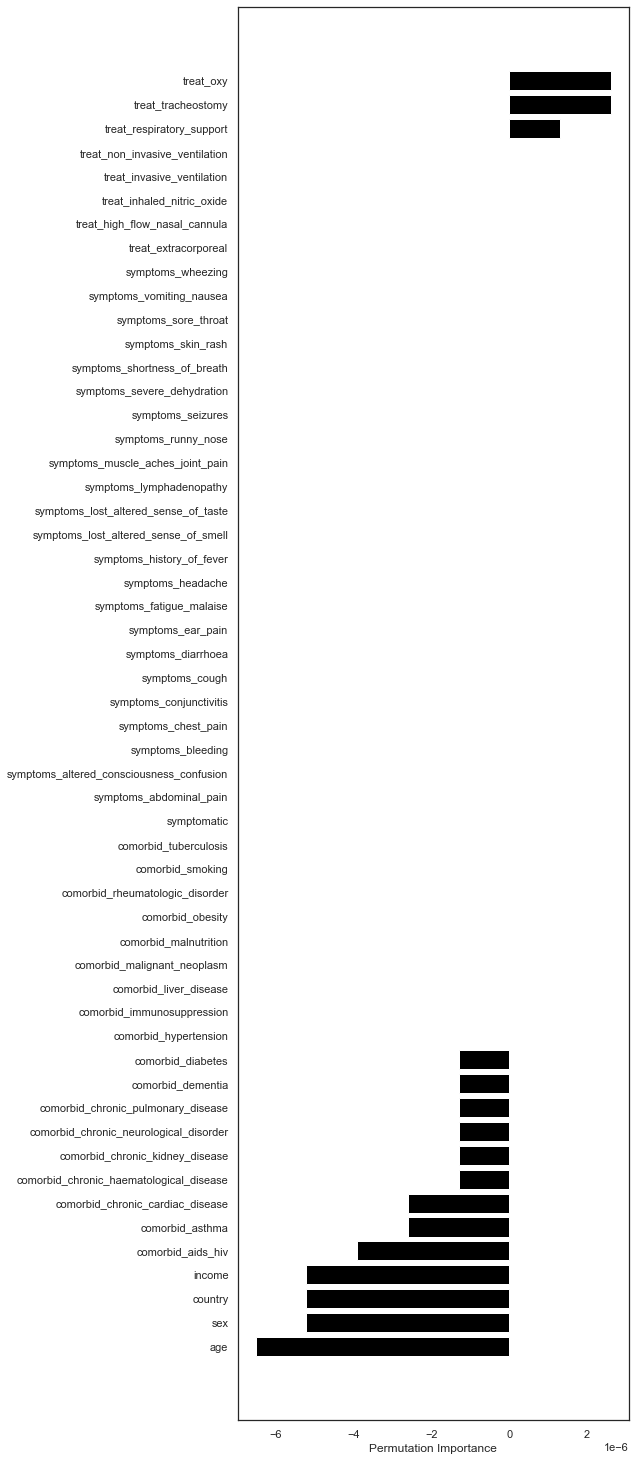

In [10]:
perm_importance = permutation_importance(XGBOOSTmodel, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(7,26))
plt.barh(features, perm_importance.importances_mean[sorted_idx], color="black")
plt.xlabel("Permutation Importance")

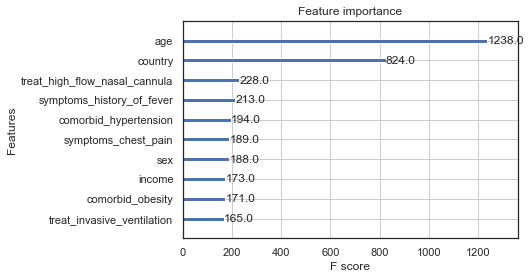

In [11]:
XGBOOSTmodel.get_booster().feature_names = features
plot_importance(XGBOOSTmodel.get_booster(), max_num_features=10)
plt.show()

# XGBoost with SMOTE

In [115]:
# Resample on the training set
smote = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('o', smote), ('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [116]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([608976,   4482]))

In [117]:
np.unique(y_res, return_counts=True)

(array([0, 1]), array([487180, 121795]))

In [118]:
# Define the model you are interested in
XGBOOSTmodel = XGBClassifier(use_label_encoder=False)

In [119]:
smote = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('o', smote), ('u', under), ('model', XGBOOSTmodel)]
model = Pipeline([
        ('sampling', smote),
        ('sampling2', under),
        ('classification', XGBOOSTmodel)
    ])

In [120]:
# Tune the XGBoost model using Bayesian optimisation
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for XGBoost hyperparameters
# Depth of tree
max_depth = np.linspace(1, 12, 12, endpoint=True)
max_depth = [round(x) for x in max_depth]
# maximum features
n_estimators = list(range(50, 400, 50))
# Learning rate
lr = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7]
# Regularisation for imbalanced data
max_delta_step = [0, 1, 3, 5, 7, 10]

# Create the grid
param_grid = {'classification__max_depth': max_depth,
               'classification__n_estimators': n_estimators,
               'classification__learning_rate': lr,
               'classification__max_delta_step': max_delta_step}

In [121]:
# Get the validation folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

In [122]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:09:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:11:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[16:39:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:40:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:06:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[17:28:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:29:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:31:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[18:03:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[18:27:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[19:09:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:10:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:12:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[19:34:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:35:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:36:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[20:09:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:11:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[20:41:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:42:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old 

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         SMOTE(random_state=42,
                                               sampling_strategy=0.2)),
                                        ('sampling2',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_byt...
                                                       use_label_encoder=False,
        

In [123]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__learning_rate', 0.01), ('classification__max_delta_step', 7), ('classification__max_depth', 5), ('classification__n_estimators', 300)])
Best AUROC: 0.9016383228530984


Best parameter combo: OrderedDict([('classification__learning_rate', 0.01), ('classification__max_delta_step', 7), ('classification__max_depth', 5), ('classification__n_estimators', 300)])
Best AUROC: 0.9016383228530984

In [124]:
# Test the model on standalone set
XGBOOSTmodel = XGBClassifier(max_depth = 5, n_estimators = 300,learning_rate = 0.01, max_delta_step = 7, use_label_encoder=False)

In [125]:
XGBOOSTmodel.fit(X_res, np.ravel(y_res))

[21:24:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=7,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [126]:
print('AUROC is:', metrics.roc_auc_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, XGBOOSTmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, XGBOOSTmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.8986548086261337
Accuracy is: 0.9755224464512764
Average Precision is: 0.05081926362265784


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


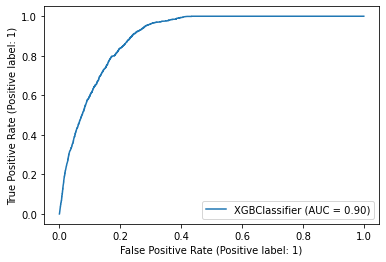

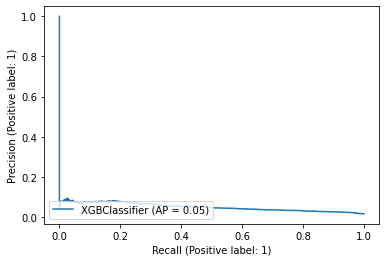

In [127]:
# Make metric plots
metrics.plot_roc_curve(XGBOOSTmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(XGBOOSTmodel, X_test, y_test) 
plt.show()

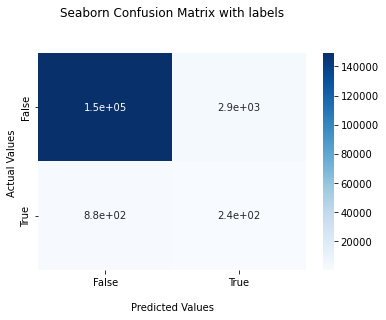

In [128]:
# Confusion matrix
ax = sns.heatmap(confusion_matrix(y_test, XGBOOSTmodel.predict(X_test)), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [129]:
# save the model trained on training set
pickle.dump(XGBOOSTmodel, open("models/xgb_PE_no_lab_measurements_with_SMOTE.pkl", "wb"))

# Random Forest without resampling

In [133]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for RF hyperparameters
# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [134]:
# Define the model you are interested in
RFmodel = RandomForestClassifier()

In [135]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(RFmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=RandomForestClassifier(), refit=False,
              scoring='roc_auc',
              search_spaces={'bootstrap': [True, False],
                             'max_depth': [10, 50, None],
                             'max_features': ['auto', 'sqrt'],
                             'min_samples_leaf': [2, 4, 10],
                             'min_samples_split': [5, 10],
                             'n_estimators': [10, 25, 50, 100, 150]},
              verbose=1)

In [136]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('bootstrap', True), ('max_depth', None), ('max_features', 'auto'), ('min_samples_leaf', 10), ('min_samples_split', 5), ('n_estimators', 150)])
Best AUROC: 0.9118891486536326


Best parameter combo: OrderedDict([('bootstrap', True), ('max_depth', None), ('max_features', 'auto'), ('min_samples_leaf', 10), ('min_samples_split', 5), ('n_estimators', 150)])
Best AUROC: 0.9118891486536326

In [137]:
# Test the model on standalone set
RFmodel = RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = 10, min_samples_split = 5, min_samples_leaf = 10, bootstrap = True)

In [138]:
RFmodel.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=5,
                       n_estimators=150)

In [139]:
print('AUROC is:', metrics.roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, RFmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, RFmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.907875566521068
Accuracy is: 0.9926971603690542
Average Precision is: 0.06877803612842343


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


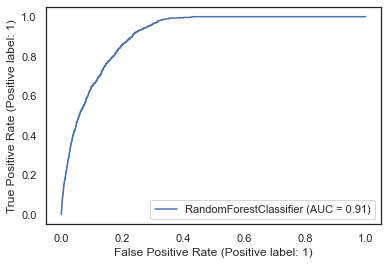

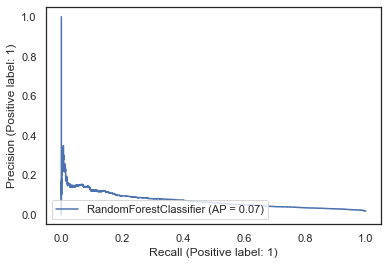

In [141]:
# Make metric plots
metrics.plot_roc_curve(RFmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(RFmodel, X_test, y_test) 
plt.show()

# Random Forest with SMOTE

In [142]:
# Resample on the training set
smote = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('o', smote), ('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [144]:
# Define the model you are interested in
RFmodel = RandomForestClassifier()

In [145]:
smote = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('o', smote), ('u', under), ('model', XGBOOSTmodel)]
model = Pipeline([
        ('sampling', smote),
        ('sampling2', under),
        ('classification', RFmodel)
    ])

In [148]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for RF hyperparameters
# Number of trees in random forest
n_estimators = [10, 25, 50, 100, 150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
param_grid = {'classification__n_estimators': n_estimators,
               'classification__max_features': max_features,
               'classification__max_depth': max_depth,
               'classification__min_samples_split': min_samples_split,
               'classification__min_samples_leaf': min_samples_leaf,
               'classification__bootstrap': bootstrap}

In [149]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         SMOTE(random_state=42,
                                               sampling_strategy=0.2)),
                                        ('sampling2',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         RandomForestClassifier())]),
              refit=False, scoring='roc_auc',
              search_spaces={'classification__bootstrap': [True, False],
                             'classification__max_depth': [10, 50, None],
                             'classification__max_features': ['auto', 'sqrt'],
                             'classification__min_samples_leaf': [2, 4, 10],
                             'classific

In [150]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__bootstrap', True), ('classification__max_depth', None), ('classification__max_features', 'auto'), ('classification__min_samples_leaf', 10), ('classification__min_samples_split', 5), ('classification__n_estimators', 150)])
Best AUROC: 0.9068194782156489


Best parameter combo: OrderedDict([('classification__bootstrap', True), ('classification__max_depth', None), ('classification__max_features', 'auto'), ('classification__min_samples_leaf', 10), ('classification__min_samples_split', 5), ('classification__n_estimators', 150)])
Best AUROC: 0.9068194782156489

In [151]:
# Test the model on standalone set
RFmodel = RandomForestClassifier(n_estimators = 150, max_features = 'auto', max_depth = None, min_samples_split = 5, min_samples_leaf = 10, bootstrap = True)

In [152]:
RFmodel.fit(X_res, np.ravel(y_res))

RandomForestClassifier(min_samples_leaf=10, min_samples_split=5,
                       n_estimators=150)

In [162]:
print('AUROC is:', metrics.roc_auc_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, RFmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, RFmodel.predict_proba(X_test)[:,1]))
print('F1 score is:', metrics.f1_score(y_test, RFmodel.predict(X_test)))

AUROC is: 0.9059178462346875
Accuracy is: 0.9892869950771036
Average Precision is: 0.05561284989408604
F1 score is: 0.06381766381766382


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


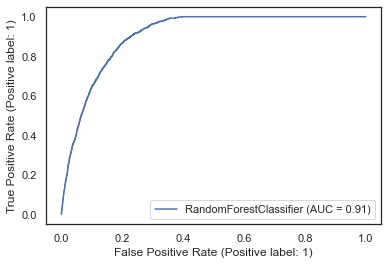

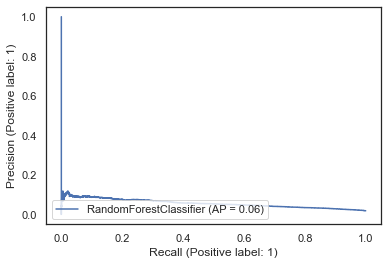

In [154]:
# Make metric plots
metrics.plot_roc_curve(RFmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(RFmodel, X_test, y_test) 
plt.show()

# Logistic Regression without Resampling

In [164]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for ElasticNet hyperparameters
# Regularisation constant
classifier__C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# Which norm to use for regularisation
classifier__penalty = ['l1', 'l2']

# Create the grid
param_grid = {'C': classifier__C,
               'penalty': classifier__penalty}

In [165]:
# Define the model you are interested in
LOGmodel = LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [166]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(LOGmodel, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           solver='liblinear'),
              refit=False, scoring='roc_auc',
              search_spaces={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                             'penalty': ['l1', 'l2']},
              verbose=1)

In [167]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('C', 0.01), ('penalty', 'l2')])
Best AUROC: 0.8987774004633028


Best parameter combo: OrderedDict([('C', 0.01), ('penalty', 'l2')])
Best AUROC: 0.8987774004633028

In [168]:
# Test the model on standalone set
LOGmodel = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight = 'balanced')

In [169]:
LOGmodel.fit(X_train, np.ravel(y_train))

LogisticRegression(C=0.01, class_weight='balanced', solver='liblinear')

In [170]:
print('AUROC is:', metrics.roc_auc_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LOGmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.8989120273712954
Accuracy is: 0.7646725132852997
Average Precision is: 0.05390311558699574


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


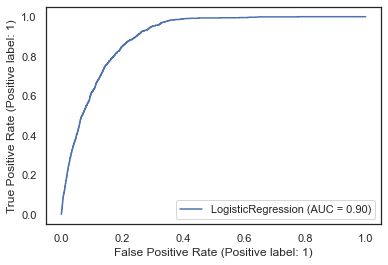

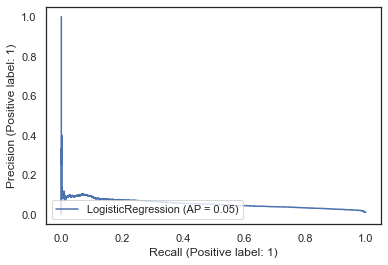

In [171]:
# Make metric plots
metrics.plot_roc_curve(LOGmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(LOGmodel, X_test, y_test) 
plt.show()

# Logistic Regression with SMOTE

In [172]:
# Resample on the training set
smote = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('o', smote), ('u', under)]
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(X_train, y_train)

In [173]:
# Define the model you are interested in
LOGmodel = LogisticRegression(solver='liblinear', class_weight = 'balanced')

In [174]:
smote = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
steps = [('o', smote), ('u', under), ('model', XGBOOSTmodel)]
model = Pipeline([
        ('sampling', smote),
        ('sampling2', under),
        ('classification', LOGmodel)
    ])

In [175]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for ElasticNet hyperparameters
# Regularisation constant
classifier__C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# Which norm to use for regularisation
classifier__penalty = ['l1', 'l2']

# Create the grid
param_grid = {'classification__C': classifier__C,
               'classification__penalty': classifier__penalty}

In [176]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=50, cv=cv, verbose=1, refit=False, scoring='roc_auc')
opt.fit(X_train, np.ravel(y_train))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=33, shuffle=True),
              estimator=Pipeline(steps=[('sampling',
                                         SMOTE(random_state=42,
                                               sampling_strategy=0.2)),
                                        ('sampling2',
                                         RandomUnderSampler(random_state=42,
                                                            sampling_strategy=0.25)),
                                        ('classification',
                                         LogisticRegression(class_weight='balanced',
                                                            solver='liblinear'))]),
              refit=False, scoring='roc_auc',
              search_spaces={'classification__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100],
                             'classification__penalty': ['l1', 'l2']},
              verbose=1)

In [177]:
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best AUROC:", opt.best_score_)

Best parameter combo: OrderedDict([('classification__C', 0.01), ('classification__penalty', 'l1')])
Best AUROC: 0.8959536790571038


Best parameter combo: OrderedDict([('classification__C', 0.01), ('classification__penalty', 'l1')])
Best AUROC: 0.8959536790571038

In [185]:
# Test the model on standalone set
LOGmodel = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', class_weight = 'balanced')

In [179]:
LOGmodel.fit(X_res, np.ravel(y_res))

LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [180]:
print('AUROC is:', metrics.roc_auc_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))
print('Accuracy is:', metrics.accuracy_score(y_test, LOGmodel.predict(X_test)))
print('Average Precision is:', metrics.average_precision_score(y_test, LOGmodel.predict_proba(X_test)[:,1]))

AUROC is: 0.8948585544681271
Accuracy is: 0.7828057249046393
Average Precision is: 0.05148775549191886


/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/COVID/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


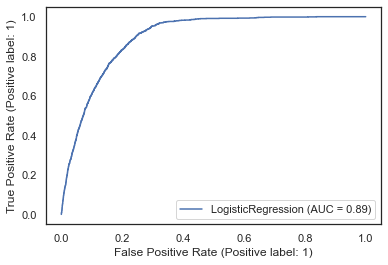

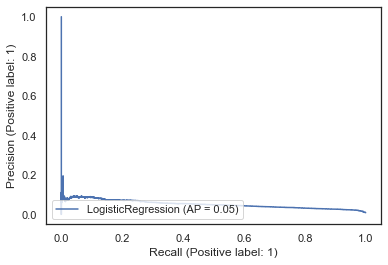

In [181]:
# Make metric plots
metrics.plot_roc_curve(LOGmodel, X_test, y_test) 
metrics.plot_precision_recall_curve(LOGmodel, X_test, y_test) 
plt.show()